# PVD Case Study (Criticality Detection)


## Introduction

In this notebook, we demonstrate how to detect the critical behavior in the system using self-supervised learning.


### Scope of the work

 1. We load the data.
 2. We create auxiliary training task.
 3. We train a model, to predict the initial parameters from the final simulation output.
 4. We measure the change in the MSE.

### Library Imports

We will pre-load all libraries that we will use in that notebook.

The notebook was tested with python 3.8, CUDA 10.1 and with the following package versions:

    Package                           Version
    --------------------------------- ----------
    numpy                             1.18.5
    pandas                            1.1.5
    scikit-image                      0.18.0
    scikit-learn                      0.24.1
    scipy                             1.4.1
    tensorflow-gpu                    2.3.0
    tensorflow-hub                    0.10.0

In [1]:
# Standard libraries
import collections
import os
import json
import random
import sys
import time

# Libraries you must install (e.g. using pip install name_of_the_library)
import numpy
import pandas
import scipy
import skimage.measure
import sklearn.cluster
import sklearn.decomposition
import sklearn.manifold
import sklearn.metrics
import tensorflow
import tensorflow_hub

# Graphic libraries
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Section 1: Input Data

### The pre-processing steps

 1. The original simulations were saved as `Nx512x512` dimensional numpy arrays.
 2. We had 12500 simulations but two arrays were corrupted.
 3. For each simulation, we selected the time step that correspond to the width equal to `224` pixels.
 4. We rejected simulations that had width smaller then `224` (only 5 simulations were rejected; we used 12493/12498 simulations).
 5. We cut four `224x224` squares from each original frame, translating the cut origin by `64` pixels each time (we apply horizontal periodic boundary conditions).
 6. We replaced values larger than 1 with 1, and smaller than -1 with -1, and then we scaled everything from 0 to 1 (we applied transformation `x -> (x+1)/2`).
 7. To speed-up the next step, we reduced the dimension of each square by two, to `112x112` pixels.
 8. We used pre-trained ResNet-v2 model to produce `2048`-size embedding of each square (in order to do this, we had to emulate the 3 channel colors by copied the one-channel input three times).

### Data Location

All the input data can be found at the ISI server `effectbig03` in the `/data/mjabram/share/pvd` folder.

Here, in order to save the memory, we load small `56x56` pixel miniatures of the original input (it will be just only for visualization purposes - to calculate the latent embedding we used higher resolution, namely `112x112`).

Note, if you run this notebook locally, change the path below so it match the location of your main data folder.

In [2]:
"""Specify the path."""
DATA_PATH = '/raw/pvd/preprocessed2b_256f32/'

In [3]:
"""Load the training data."""
data = numpy.load(os.path.join(DATA_PATH, 'pvd2b_singles_256f32t09_width224_x4_reduced_to_56x56mean.npy'))
data.shape, data.dtype

((49972, 56, 56, 1), dtype('float32'))

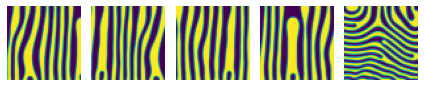

In [4]:
def plot_frames(data, *arr, cmap='viridis', title=None, axis=None):
    """Plot selected frames."""
    if title:
        print(title)
    fig, axes = plt.subplots(1, len(arr))
    for i, k in enumerate(arr):
        a = axes if len(arr) == 1 else axes[i]
        if not axis:
            a.axis('off');
        fig.tight_layout() 
        a.imshow(data[k], cmap=cmap)
    plt.show()


"""Plot last frames from a few simulations."""
plot_frames(data, 0, 1, 2, 3, 4)  # note, we count the simulations from 0 not from 1

(0.0, 1.0, 0.4999559)

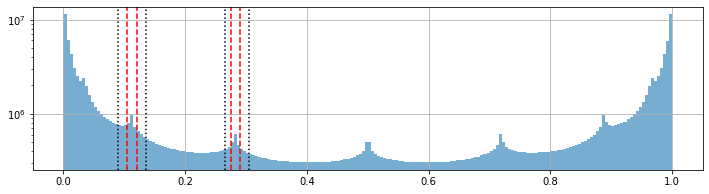

In [5]:
"""Plot the distribution.

There are some "bumps". Those bumps exist already in the original data.
There are not effect of the preprocessing procedure. See the analysis
below.
"""
fig, ax = plt.subplots()
pandas.Series(data.flatten()).hist(bins=200, figsize=(12, 3), alpha=0.6)
ax.set_yscale('log')
plt.axvline(x=(1-0.73)/2, color='k', linestyle=':')
plt.axvline(x=(1-0.82)/2, color='k', linestyle=':')
plt.axvline(x=(1-0.76)/2, color='r', linestyle='--')
plt.axvline(x=(1-0.79)/2, color='r', linestyle='--')

plt.axvline(x=(1-0.39)/2, color='k', linestyle=':')
plt.axvline(x=(1-0.47)/2, color='k', linestyle=':')
plt.axvline(x=(1-0.45)/2, color='r', linestyle='--')
plt.axvline(x=(1-0.42)/2, color='r', linestyle='--')

data.min(), data.max(), data.mean()

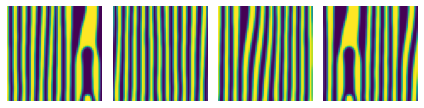

The First "Bump"


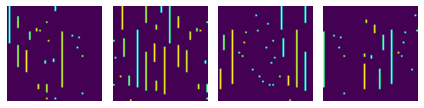

vs.


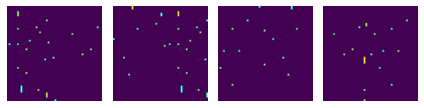

In [6]:
"""Check where the extensive pixels from the first "bump" are grouped."""
plot_frames(data, 16, 17, 18, 19)

print('The First "Bump"')
temp = numpy.where((data > (1-0.79)/2) & (data < (1-0.76)/2), 1, 0).astype('float32')
plot_frames(temp, 16, 17, 18, 19)

print('vs.')
temp = numpy.where((data > (1-0.76)/2) & (data < (1-0.73)/2), 1, 0).astype('float32')
plot_frames(temp, 16, 17, 18, 19)

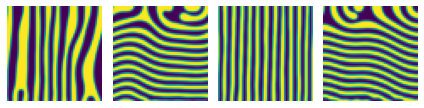

The Second "Bump"


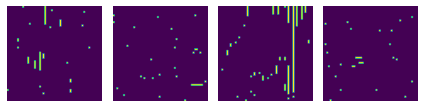

vs.


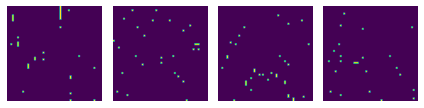

In [7]:
"""Check where the extensive pixels from the second "bump" are grouped."""
plot_frames(data, 1, 22, 22319, 45604)

print('The Second "Bump"')
temp = numpy.where((data > (1-0.45)/2) & (data < (1-0.42)/2), 1, 0).astype('float32')
plot_frames(temp, 1, 22, 22319, 45604)

print('vs.')

temp = numpy.where((data > (1-0.48)/2) & (data < (1-0.45)/2), 1, 0).astype('float32')
plot_frames(temp, 1, 22, 22319, 45604)

**Interpretation:**

Those bumps exist already in the original data. There are not effect of the preprocessing procedure. They correspond to the vertical and (less frequently) to the horizontal phase boundaries. They are most likely either an effects of the fine precision of the original simulation or an effect of numerical type conversion (e.g. `float64 -> float32`) and aggregation of results.

However, since the number of those excessive pixels is still at least 10 times smaller then the "correct" pixels (note the logarithmic scale), we do not feel like this would be any problem.

### Parameters

We load the initial parameters.

In [8]:
parameters = pandas.read_csv(os.path.join(
    DATA_PATH, 'pvd2b_singles_256f32t09_width224_x4_parameters.csv'))
parameters

,name_id,angle,s_mob_b,b_mob_b,b_mob_a,s_mob_a,vel,dt,n_iter,out_freq,n,width,shape
0,data_10_run.187,67.743247,1.640402,0.718857,9.331576,79.222896,0.137287,3,4290000.0,42900.0,82,224,"[101, 512, 512]"
1,data_10_run.187,67.743247,1.640402,0.718857,9.331576,79.222896,0.137287,3,4290000.0,42900.0,82,224,"[101, 512, 512]"
2,data_10_run.187,67.743247,1.640402,0.718857,9.331576,79.222896,0.137287,3,4290000.0,42900.0,82,224,"[101, 512, 512]"
3,data_10_run.187,67.743247,1.640402,0.718857,9.331576,79.222896,0.137287,3,4290000.0,42900.0,82,224,"[101, 512, 512]"
4,data_12_run.446,69.116024,12.241171,3.341605,7.698050,16.447733,0.794076,3,840000.0,8400.0,70,226,"[101, 512, 512]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49967,data_31_run.105,30.714403,43.399504,7.516182,9.518049,20.868461,0.947312,3,1270000.0,12700.0,69,226,"[101, 512, 512]"
49968,data_30_run.208,59.180990,5.403073,1.863789,6.455396,11.736113,0.616192,3,1160000.0,11600.0,69,226,"[101, 512, 512]"
49969,data_30_run.208,59.180990,5.403073,1.863789,6.455396,11.736113,0.616192,3,1160000.0,11600.0,69,226,"[101, 512, 512]"
49970,data_30_run.208,59.180990,5.403073,1.863789,6.455396,11.736113,0.616192,3,1160000.0,11600.0,69,226,"[101, 512, 512]"


In [9]:
"""Extract information about the data id and run id."""
parameters['data_id'] = [int(i[5:7]) for i in parameters.name_id]
parameters['run_id'] = [int(i.split('.')[-1]) for i in parameters.name_id]
parameters['dr_id'] = [(int(i[5:7]), int(i.split('.')[-1])) for i in parameters.name_id]
parameters[[
    'name_id',  'dr_id', 'data_id', 'run_id',
    'angle', 's_mob_b', 'b_mob_b', 'b_mob_a', 's_mob_a', 'vel', 'dt',
    'n_iter', 'out_freq', 'n', 'width'#, 'shape'
]]

,name_id,dr_id,data_id,run_id,angle,s_mob_b,b_mob_b,b_mob_a,s_mob_a,vel,dt,n_iter,out_freq,n,width
0,data_10_run.187,"(10, 187)",10,187,67.743247,1.640402,0.718857,9.331576,79.222896,0.137287,3,4290000.0,42900.0,82,224
1,data_10_run.187,"(10, 187)",10,187,67.743247,1.640402,0.718857,9.331576,79.222896,0.137287,3,4290000.0,42900.0,82,224
2,data_10_run.187,"(10, 187)",10,187,67.743247,1.640402,0.718857,9.331576,79.222896,0.137287,3,4290000.0,42900.0,82,224
3,data_10_run.187,"(10, 187)",10,187,67.743247,1.640402,0.718857,9.331576,79.222896,0.137287,3,4290000.0,42900.0,82,224
4,data_12_run.446,"(12, 446)",12,446,69.116024,12.241171,3.341605,7.698050,16.447733,0.794076,3,840000.0,8400.0,70,226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49967,data_31_run.105,"(31, 105)",31,105,30.714403,43.399504,7.516182,9.518049,20.868461,0.947312,3,1270000.0,12700.0,69,226
49968,data_30_run.208,"(30, 208)",30,208,59.180990,5.403073,1.863789,6.455396,11.736113,0.616192,3,1160000.0,11600.0,69,226
49969,data_30_run.208,"(30, 208)",30,208,59.180990,5.403073,1.863789,6.455396,11.736113,0.616192,3,1160000.0,11600.0,69,226
49970,data_30_run.208,"(30, 208)",30,208,59.180990,5.403073,1.863789,6.455396,11.736113,0.616192,3,1160000.0,11600.0,69,226


In [10]:
assert len(data) == len(parameters)

### Feature Vectors (The Latent Space)

To create feature vector from an image we can use one of the pre-trained models available in TensorFlow Hub. Here, we decided to use the **ResNet V2** model. The key difference with the V1 is the use of batch normalization. ResNet 50 has 50 layers and was trained on standard ImageNet-1k detaset (ILSVRC-2012-CLS). The feature vector has size `2048`. The input images are expected to have color values in the range `[0,1]` and the expected size of the input images is `224x224` pixels by default, but other input sizes are possible (within limits). See more at https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4.

Note, that this model require 3-channel input.

We have already pre-computed the latent vector. Here, we will only load it up.

In [11]:
feature_vector = numpy.load(
    os.path.join(DATA_PATH, 'pvd2b_singles_256f32t09_width224_x4_feature_vector.npy'))
feature_vector.shape

(49972, 2048)

In [12]:
assert len(data) == len(feature_vector)

## Section 2: Auxiliary Training Task

### Training and Validation Dataset

We had 12500 double files, two were corrupted, 5 had width that was too small. The number of simulations I have access to is 12293. Because we cut four squares from each simulation, we should have 49172 individual datapoints in total.

I take 40% random simulations as my validation set.

Note, that simulations were repeated 5 times for each datapoint. Thus, we should have only about 2498 unique sets of parameters.

In [13]:
%%time
import hashlib

"""Calculate hash for each unique set of parameters."""
hashlist = []
for row in parameters.iloc:
    p = [str(i) for i in row[['angle', 'b_mob_a', 'b_mob_b', 's_mob_a', 's_mob_b', 'vel', 'dt']]]
    s = '_'.join(p)
    h = hashlib.md5(s.encode()).hexdigest()[:16]  # the original md5sum has 32 character.
    hashlist.append(h)
    
parameters['hash'] = hashlist

CPU times: user 21.7 s, sys: 21.5 ms, total: 21.7 s
Wall time: 21.7 s


In [14]:
"""Veryfy how many datapoints share the same set of parameters."""
hash_counter = collections.Counter(parameters.hash)
collections.Counter(hash_counter.values())

Counter({20: 2497, 16: 2})

In [15]:
"""Veryfy how many datapoints have dt == 2 vs. 3."""
dt_counter = collections.Counter(parameters.dt)
dt_counter

Counter({3: 47112, 2: 2860})

In [16]:
"""If some datapoints are missing, we will reject the entire set.

We also reject cases with dt == 2
"""
unique_hash = list(set(
    [h for h, d in zip(parameters.hash, parameters.dt) if hash_counter[h] == 20 and d == 3]))

len(unique_hash)

2354

In [17]:
"""We will shuffle the hashes and we will split them into training and test sets."""
print(unique_hash[:5])
random.shuffle(unique_hash)
print(unique_hash[:5])

train_hash = set(unique_hash[:int(len(unique_hash)*0.6)])
valid_hash = set(unique_hash[int(len(unique_hash)*0.6):])

len(train_hash), len(valid_hash)

['c531c9fdb629c2d1', '974c273bf5d21acb', '24458add2b07e75a', '9bc9ba3eeb2a1151', 'dbf174518c87b9f9']
['f1de473360b911c9', '4db4bb6f2bfdbf29', '27a0b4da10d438e0', '3415f01e49b11206', 'a97d7db2c65bfa2f']


(1412, 942)

In [18]:
"""We will add information if given datapoint belogs to the training or the validation set."""
parameters['training'] = [h in train_hash for h in parameters.hash]
parameters['validation'] = [h in valid_hash for h in parameters.hash]

sum(parameters['training']), sum(parameters['validation'])

(28240, 18840)

In [19]:
"""Sanity Check"""
assert any(parameters.training & parameters.validation) is False

"""Display"""
display(parameters[[
    'name_id', 'dr_id', 'hash', 'training', 'validation',
    'angle', 'b_mob_a', 'b_mob_b', 's_mob_a', 's_mob_b', 'vel', 'dt']])

"""Count datapoints that are neither in training nor in validation."""
sum((parameters.training == False) & (parameters.validation == False))

,name_id,dr_id,hash,training,validation,angle,b_mob_a,b_mob_b,s_mob_a,s_mob_b,vel,dt
0,data_10_run.187,"(10, 187)",93c8903afa0a1680,True,False,67.743247,9.331576,0.718857,79.222896,1.640402,0.137287,3
1,data_10_run.187,"(10, 187)",93c8903afa0a1680,True,False,67.743247,9.331576,0.718857,79.222896,1.640402,0.137287,3
2,data_10_run.187,"(10, 187)",93c8903afa0a1680,True,False,67.743247,9.331576,0.718857,79.222896,1.640402,0.137287,3
3,data_10_run.187,"(10, 187)",93c8903afa0a1680,True,False,67.743247,9.331576,0.718857,79.222896,1.640402,0.137287,3
4,data_12_run.446,"(12, 446)",4593da90ac4200af,True,False,69.116024,7.698050,3.341605,16.447733,12.241171,0.794076,3
...,...,...,...,...,...,...,...,...,...,...,...,...
49967,data_31_run.105,"(31, 105)",ad78fc6bfa4845bf,True,False,30.714403,9.518049,7.516182,20.868461,43.399504,0.947312,3
49968,data_30_run.208,"(30, 208)",0fe22d0aed80c790,True,False,59.180990,6.455396,1.863789,11.736113,5.403073,0.616192,3
49969,data_30_run.208,"(30, 208)",0fe22d0aed80c790,True,False,59.180990,6.455396,1.863789,11.736113,5.403073,0.616192,3
49970,data_30_run.208,"(30, 208)",0fe22d0aed80c790,True,False,59.180990,6.455396,1.863789,11.736113,5.403073,0.616192,3


2892

In [20]:
"""Add the order parameter."""
parameters['order0'] = numpy.log(
    parameters.vel/((parameters.b_mob_a + parameters.b_mob_b)/2))

parameters['order1'] = numpy.log(
    numpy.sin(parameters.angle*numpy.pi/180)*parameters.vel/((parameters.b_mob_a + parameters.b_mob_b)/2))

In [21]:
"""Split the data and parameters sets accordingly."""
train_f = feature_vector[parameters.training]
train_p = parameters[parameters.training][[
    'name_id', 'dr_id', 'hash', 'training', 'validation',
    'angle', 'b_mob_a', 'b_mob_b', 's_mob_a', 's_mob_b', 'vel', 'dt', 'order0', 'order1']]
train_data = data[parameters.training]

valid_f = feature_vector[parameters.validation]
valid_p = parameters[parameters.validation][[
    'name_id', 'dr_id', 'hash', 'training', 'validation',
    'angle', 'b_mob_a', 'b_mob_b', 's_mob_a', 's_mob_b', 'vel', 'dt', 'order0', 'order1']]
valid_data = data[parameters.validation]

"""Display"""
display(train_p.head())
display(valid_p.head())
train_f.shape, train_p.shape, valid_f.shape, valid_p.shape, train_data.shape

,name_id,dr_id,hash,training,validation,angle,b_mob_a,b_mob_b,s_mob_a,s_mob_b,vel,dt,order0,order1
0,data_10_run.187,"(10, 187)",93c8903afa0a1680,True,False,67.743247,9.331576,0.718857,79.222896,1.640402,0.137287,3,-3.600150,-3.677576
1,data_10_run.187,"(10, 187)",93c8903afa0a1680,True,False,67.743247,9.331576,0.718857,79.222896,1.640402,0.137287,3,-3.600150,-3.677576
2,data_10_run.187,"(10, 187)",93c8903afa0a1680,True,False,67.743247,9.331576,0.718857,79.222896,1.640402,0.137287,3,-3.600150,-3.677576
3,data_10_run.187,"(10, 187)",93c8903afa0a1680,True,False,67.743247,9.331576,0.718857,79.222896,1.640402,0.137287,3,-3.600150,-3.677576
4,data_12_run.446,"(12, 446)",4593da90ac4200af,True,False,69.116024,7.698050,3.341605,16.447733,12.241171,0.794076,3,-1.938923,-2.006876


,name_id,dr_id,hash,training,validation,angle,b_mob_a,b_mob_b,s_mob_a,s_mob_b,vel,dt,order0,order1
28,data_03_run.322,"(3, 322)",e7759f60632465b2,False,True,58.473464,6.095718,7.700789,46.170109,29.078123,0.763159,3,-2.201557,-2.361259
29,data_03_run.322,"(3, 322)",e7759f60632465b2,False,True,58.473464,6.095718,7.700789,46.170109,29.078123,0.763159,3,-2.201557,-2.361259
30,data_03_run.322,"(3, 322)",e7759f60632465b2,False,True,58.473464,6.095718,7.700789,46.170109,29.078123,0.763159,3,-2.201557,-2.361259
31,data_03_run.322,"(3, 322)",e7759f60632465b2,False,True,58.473464,6.095718,7.700789,46.170109,29.078123,0.763159,3,-2.201557,-2.361259
40,data_10_run.490,"(10, 490)",90a94a8a5b92e1f6,False,True,69.734762,8.294837,3.814070,48.341911,11.009824,0.132999,3,-3.818207,-3.882107


((28240, 2048), (28240, 14), (18840, 2048), (18840, 14), (28240, 56, 56, 1))

### Distributions Visualization

We visualize the training and validation distributions.

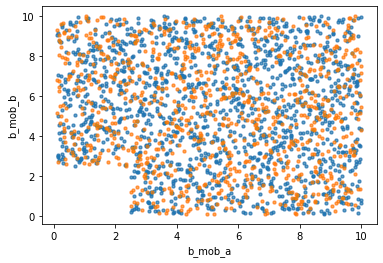

In [22]:
"""Check distribution of the training and validation sets."""
plt.plot(train_p.b_mob_a, train_p.b_mob_b, '.', alpha=0.05)
plt.plot(valid_p.b_mob_a, valid_p.b_mob_b, '.', alpha=0.05)
plt.xlabel('b_mob_a'); plt.ylabel('b_mob_b')
plt.show()

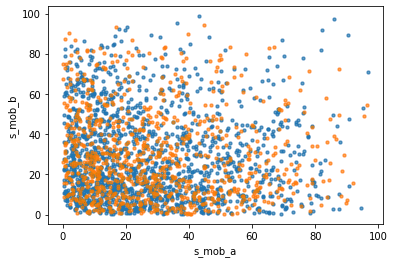

In [23]:
"""Check distribution of the training and validation sets."""
plt.plot(train_p.s_mob_a, train_p.s_mob_b, '.', alpha=0.05)
plt.plot(valid_p.s_mob_a, valid_p.s_mob_b, '.', alpha=0.05)
plt.xlabel('s_mob_a'); plt.ylabel('s_mob_b')
plt.show()

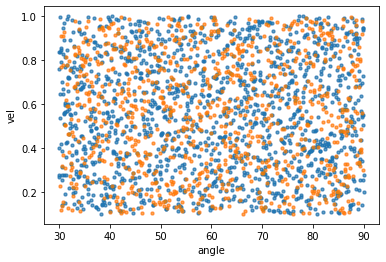

In [24]:
"""Check distribution of the training and validation sets."""
plt.plot(train_p.angle, train_p.vel, '.', alpha=0.05)
plt.plot(valid_p.angle, valid_p.vel, '.', alpha=0.05)
plt.xlabel('angle'); plt.ylabel('vel')
plt.show()

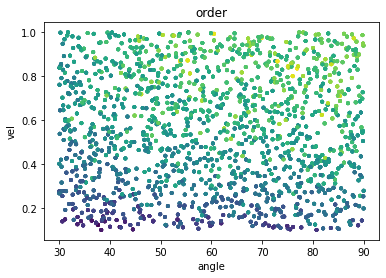

In [25]:
"""Check distribution of the cases with dt = 2 and dt = 3."""
plt.scatter(
    train_p.angle, train_p.vel, marker='o',
    c=train_p.order1, s=8, alpha=0.4)
plt.xlabel('angle'); plt.ylabel('vel');
plt.title('order')
plt.show()

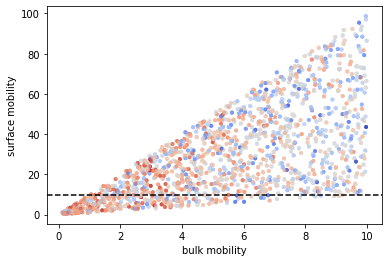

In [26]:
"""Check relation of bulk mobility to surface mobility."""
plt.scatter(
    train_p.b_mob_b, train_p.s_mob_b, marker='o',
    cmap=plt.cm.coolwarm, c=train_p.order1, s=8, alpha=0.1)
plt.axhline(y=10, linestyle='--', linewidth=1.5, color='k')
plt.xlabel('bulk mobility'); plt.ylabel('surface mobility')
plt.show()

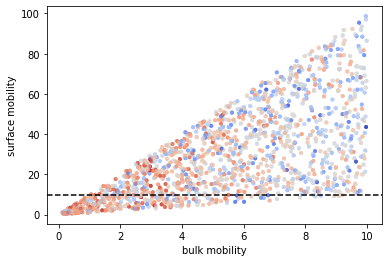

In [27]:
"""Check relation of bulk mobility to surface mobility."""
plt.scatter(
    train_p.b_mob_b, train_p.s_mob_b, marker='o',
    cmap=plt.cm.coolwarm, c=train_p.order1, s=8, alpha=0.1)
plt.axhline(y=10, linestyle='--', linewidth=1.5, color='k')
plt.xlabel('bulk mobility'); plt.ylabel('surface mobility')
plt.show()

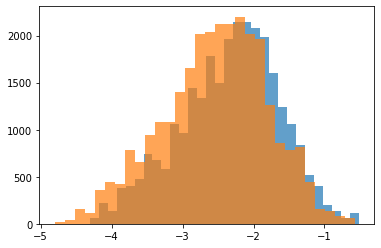

In [28]:
plt.hist(train_p.order0, alpha=0.7, bins=30)
plt.hist(train_p.order1, alpha=0.7, bins=30)
plt.show()

vel -4.500 -- -4.000, len 11


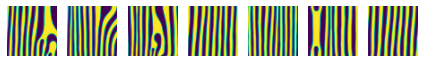

vel -4.000 -- -3.500, len 51


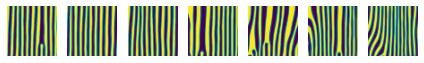

vel -3.500 -- -3.000, len 99


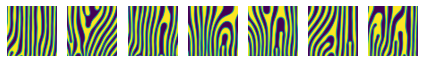

vel -3.000 -- -2.500, len 188


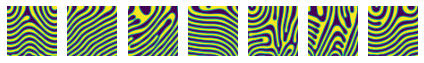

vel -2.500 -- -2.000, len 248


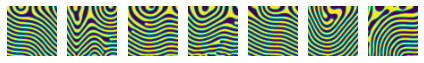

vel -2.000 -- -1.500, len 219


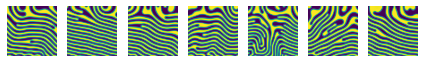

vel -1.500 -- -1.000, len 85


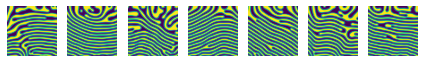

vel -1.000 -- -0.500, len 17


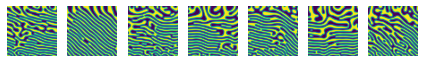

In [29]:
"""Visualize the transition from vertical to horizontal stripes."""
for d in numpy.linspace(-6, 0, 13):
    #mask = (train_p.angle > 60) & (train_p.dt == 3) & \
    #       (train_p.vel < .05 + d) & (train_p.vel > 0 + d) & \
    #       (train_p.s_mob_a > 10) & (train_p.s_mob_b > 10)
     
    mask = (train_p.angle < 89) & (train_p.angle > 50) & \
           (train_p.order0< .5 + d) & (train_p.order0 > 0 + d)
        
    if all(mask == False):
        continue
    
    print(f'vel {d:.3f} -- {d+0.5:.3f}, len {sum(mask)//20}')
    r = numpy.random.randint(len(train_data[mask]), size=(7, ))
    plot_frames(train_data[mask], *r)

## Section 3: Model Training

We predict the initial parameters from the final microstructure orientation.

In [31]:
"""Training and validation data."""
train_mask = (train_p.angle < 89) & (train_p.angle > 50) & (train_p.dt == 3)
valid_mask = (valid_p.angle < 89) & (valid_p.angle > 50) & (valid_p.dt == 3)

train_x = train_f.copy()[train_mask]
valid_x = valid_f.copy()[valid_mask]

train_x.shape, valid_x.shape, train_f.shape, valid_f.shape

((18360, 2048), (12420, 2048), (28240, 2048), (18840, 2048))

In [32]:
"""Training and validation target."""
train_target = train_p[train_mask].copy()[[
    'angle', 'b_mob_a', 'b_mob_b', 's_mob_a', 's_mob_b', 'vel']]
valid_target = valid_p[valid_mask].copy()[[
    'angle', 'b_mob_a', 'b_mob_b', 's_mob_a', 's_mob_b', 'vel']]

train_target

,angle,b_mob_a,b_mob_b,s_mob_a,s_mob_b,vel
0,67.743247,9.331576,0.718857,79.222896,1.640402,0.137287
1,67.743247,9.331576,0.718857,79.222896,1.640402,0.137287
2,67.743247,9.331576,0.718857,79.222896,1.640402,0.137287
3,67.743247,9.331576,0.718857,79.222896,1.640402,0.137287
4,69.116024,7.698050,3.341605,16.447733,12.241171,0.794076
...,...,...,...,...,...,...
49959,70.897905,7.751811,0.569424,20.648484,0.714076,0.849027
49968,59.180990,6.455396,1.863789,11.736113,5.403073,0.616192
49969,59.180990,6.455396,1.863789,11.736113,5.403073,0.616192
49970,59.180990,6.455396,1.863789,11.736113,5.403073,0.616192


In [33]:
"""Normalize target."""
normalization = {
    'angle': 90,
    'b_mob_a': 10,
    'b_mob_b': 10,
    's_mob_a': 100,
    's_mob_b': 100,
    'vel': 1
}

train_target_normalized = train_target.copy()
valid_target_normalized = valid_target.copy()

for n in ['angle', 'b_mob_a', 'b_mob_b', 's_mob_a', 's_mob_b', 'vel']:    
    train_target_normalized[n] /= normalization[n]
    valid_target_normalized[n] /= normalization[n]
    
train_target_normalized

,angle,b_mob_a,b_mob_b,s_mob_a,s_mob_b,vel
0,0.752703,0.933158,0.071886,0.792229,0.016404,0.137287
1,0.752703,0.933158,0.071886,0.792229,0.016404,0.137287
2,0.752703,0.933158,0.071886,0.792229,0.016404,0.137287
3,0.752703,0.933158,0.071886,0.792229,0.016404,0.137287
4,0.767956,0.769805,0.334160,0.164477,0.122412,0.794076
...,...,...,...,...,...,...
49959,0.787755,0.775181,0.056942,0.206485,0.007141,0.849027
49968,0.657567,0.645540,0.186379,0.117361,0.054031,0.616192
49969,0.657567,0.645540,0.186379,0.117361,0.054031,0.616192
49970,0.657567,0.645540,0.186379,0.117361,0.054031,0.616192


In [34]:
"""All the values should be from 0 to 1."""
train_target.describe()

,angle,b_mob_a,b_mob_b,s_mob_a,s_mob_b,vel
count,18360.000000,18360.000000,18360.000000,18360.000000,18360.000000,18360.000000
mean,69.682487,5.218603,5.283768,28.358117,28.829579,0.551412
std,11.065137,2.779881,2.849518,21.464775,22.142180,0.258186
min,50.042282,0.121127,0.118830,0.341453,0.394594,0.100228
25%,60.272929,2.983667,2.878951,11.115617,10.900231,0.338094
50%,69.966137,5.196424,5.328708,23.021453,22.968126,0.541923
75%,79.041362,7.596285,7.750859,41.735568,43.562461,0.772323
max,88.981631,9.980052,9.990471,96.604574,98.604960,0.999470


In [35]:
"""The mean value for the validation set should be similar to the mean value in the training set."""
valid_target.describe()

,angle,b_mob_a,b_mob_b,s_mob_a,s_mob_b,vel
count,12420.000000,12420.000000,12420.000000,12420.000000,12420.000000,12420.000000
mean,69.258104,5.260618,5.255183,29.096558,29.420925,0.546999
std,11.570762,2.789717,2.761294,21.191297,21.043323,0.264063
min,50.025423,0.110185,0.111815,0.281533,0.381455,0.100280
25%,59.220903,2.878211,3.021171,11.402003,11.644456,0.313459
50%,68.489190,5.382599,5.203969,25.285059,25.579900,0.549953
75%,79.717106,7.730743,7.583805,42.752817,43.197608,0.777183
max,88.975499,9.994445,9.995216,96.516013,94.379330,0.996574


In [36]:
valid_target_normalized.describe()

,angle,b_mob_a,b_mob_b,s_mob_a,s_mob_b,vel
count,12420.000000,12420.000000,12420.000000,12420.000000,12420.000000,12420.000000
mean,0.769534,0.526062,0.525518,0.290966,0.294209,0.546999
std,0.128564,0.278972,0.276129,0.211913,0.210433,0.264063
min,0.555838,0.011018,0.011182,0.002815,0.003815,0.100280
25%,0.658010,0.287821,0.302117,0.114020,0.116445,0.313459
50%,0.760991,0.538260,0.520397,0.252851,0.255799,0.549953
75%,0.885746,0.773074,0.758381,0.427528,0.431976,0.777183
max,0.988617,0.999444,0.999522,0.965160,0.943793,0.996574


### Train Networks (Angle)

In [36]:
"""Construct a dataset and shuffle the data."""
training_dataset = tensorflow.data.Dataset.from_tensor_slices(
    (train_x, train_target_normalized.angle)).shuffle(buffer_size=10**5, seed=42).batch(32)
training_dataset

<BatchDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float64)>

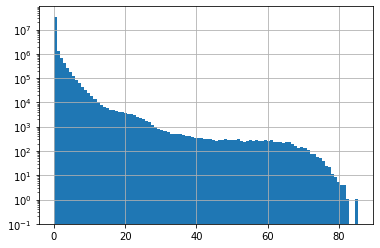

In [37]:
fig, ax = plt.subplots()
pandas.Series(train_x.flatten()).hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

In [38]:
"""Build a simple neural network."""
angle_logs = []
angle_delta = []
for i in range(20):
    # Build
    m0 = tensorflow.keras.Sequential([
        tensorflow.keras.layers.Dense(2048, activation='relu', input_shape=(2048,)),
        tensorflow.keras.layers.Dropout(0.2),
        tensorflow.keras.layers.Dense(1, activation='linear')
    ])

    # Compile
    m0.compile(
        optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss=tensorflow.keras.losses.MeanSquaredError(),
        metrics=[
            tensorflow.keras.metrics.MeanAbsoluteError(name='mae'),
            tensorflow.keras.metrics.MeanAbsolutePercentageError(name='mape')],
    )

    # Train
    callback = tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_mae', patience=4, min_delta=0.001, mode='min'
    )
    m0_log =  m0.fit(
        training_dataset, epochs=30, verbose=0, callbacks=[callback],
        validation_data=(valid_x, valid_target_normalized.angle),
    )
    
    # Predict
    valid_pred = pandas.DataFrame(
        m0.predict(valid_x)*90, columns=['angle'])
    valid_delta = numpy.abs(
        valid_pred.copy().reset_index(drop=True) - valid_target.copy().reset_index(drop=True)).angle
    
    # Save
    angle_logs.append(m0_log)
    angle_delta.append(valid_delta)
    
    del m0
    
angle_delta = numpy.array(angle_delta)
angle_delta.shape

(20, 12400)

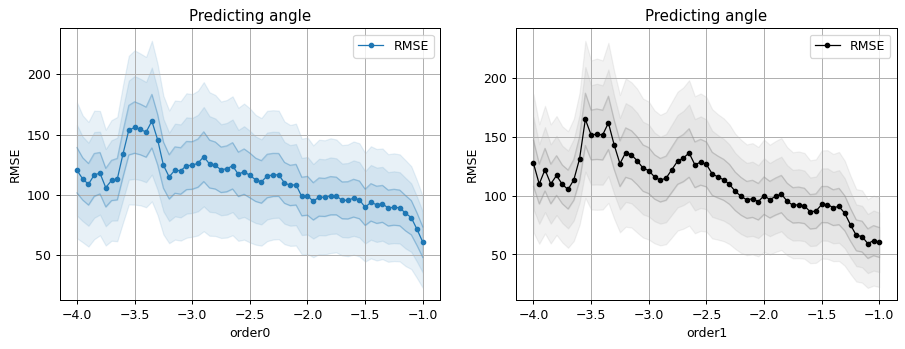

In [75]:
# Check the performance
REN = numpy.sqrt(20)

rmse0, rmse0s = [], []
rmse1, rmse1s = [], []
frac = numpy.linspace(-4, -1, 61)
delta = 0.15
for f in frac:
    mask0 = numpy.abs(f - valid_p[valid_mask].reset_index().order0) < delta    
    rmse0.append((angle_delta.mean(axis=0)[mask0]**2).mean())
    rmse0s.append(2*angle_delta.std(axis=0)[mask0].mean()*angle_delta.mean(axis=0)[mask0].mean()/REN)
    
    mask1 = numpy.abs(f - valid_p[valid_mask].reset_index().order1) < delta    
    rmse1.append((angle_delta.mean(axis=0)[mask1]**2).mean())
    rmse1s.append(2*angle_delta.std(axis=0)[mask1].mean()*angle_delta.mean(axis=0)[mask1].mean()/REN)

rmse0 = numpy.array(rmse0)
rmse1 = numpy.array(rmse1)
rmse0s = numpy.array(rmse0s)
rmse1s = numpy.array(rmse1s)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=90)
axes[0].plot(frac, rmse0, '.-', label='RMSE', linewidth=1, markersize=7)
axes[0].plot(frac, rmse0 + rmse0s, '-', linewidth=1, markersize=7, alpha=0.3, color='tab:blue')
axes[0].plot(frac, rmse0 - rmse0s, '-', linewidth=1, markersize=7, alpha=0.3, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 1*rmse0s, y2=rmse0 + 1*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 2*rmse0s, y2=rmse0 + 2*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 3*rmse0s, y2=rmse0 + 3*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].legend(); axes[0].grid(); axes[0].set_xlabel('order0'); axes[0].set_ylabel('RMSE')

axes[1].plot(frac, rmse1, 'k.-', label='RMSE', linewidth=1, markersize=7)
axes[1].plot(frac, rmse1 + rmse1s, '-', linewidth=1, markersize=7, alpha=0.3, color='grey')
axes[1].plot(frac, rmse1 - rmse1s, '-', linewidth=1, markersize=7, alpha=0.3, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 1*rmse1s, y2=rmse1 + 1*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 2*rmse1s, y2=rmse1 + 2*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 3*rmse1s, y2=rmse1 + 3*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].legend(); axes[1].grid(); axes[1].set_xlabel('order1'); axes[1].set_ylabel('RMSE')

axes[0].set_title('Predicting angle')
axes[1].set_title('Predicting angle')
plt.show()

### Train Networks (b_mob_a)

In [40]:
"""Construct a dataset and shuffle the data."""
training_dataset = tensorflow.data.Dataset.from_tensor_slices(
    (train_x, train_target_normalized.b_mob_a)).shuffle(buffer_size=10**5, seed=42).batch(32)
training_dataset

<BatchDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float64)>

In [41]:
"""Build a simple neural network."""
b_mob_a_logs = []
b_mob_a_delta = []
for i in range(20):
    # Build
    m0 = tensorflow.keras.Sequential([
        tensorflow.keras.layers.Dense(2048, activation='relu', input_shape=(2048,)),
        tensorflow.keras.layers.Dropout(0.2),
        tensorflow.keras.layers.Dense(1, activation='linear')
    ])

    # Compile
    m0.compile(
        optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss=tensorflow.keras.losses.MeanSquaredError(),
        metrics=[
            tensorflow.keras.metrics.MeanAbsoluteError(name='mae'),
            tensorflow.keras.metrics.MeanAbsolutePercentageError(name='mape')],
    )

    # Train
    callback = tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_mae', patience=4, min_delta=0.001, mode='min'
    )
    m0_log =  m0.fit(
        training_dataset, epochs=30, verbose=0, callbacks=[callback],
        validation_data=(valid_x, valid_target_normalized.b_mob_a),
    )
    
    # Predict
    valid_pred = pandas.DataFrame(
        m0.predict(valid_x)*10, columns=['b_mob_a'])
    valid_delta = numpy.abs(
        valid_pred.copy().reset_index(drop=True) - valid_target.copy().reset_index(drop=True)).b_mob_a
    
    # Save
    b_mob_a_logs.append(m0_log)
    b_mob_a_delta.append(valid_delta)
    
    del m0

    
b_mob_a_delta = numpy.array(b_mob_a_delta)
b_mob_a_delta.shape

(20, 12400)

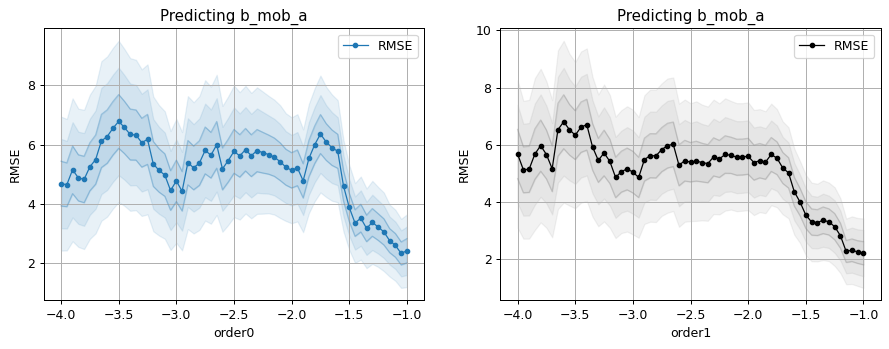

In [76]:
# Check the performance
REN = numpy.sqrt(20)

rmse0, rmse0s = [], []
rmse1, rmse1s = [], []
frac = numpy.linspace(-4, -1, 61)
delta = 0.15
for f in frac:
    mask0 = numpy.abs(f - valid_p[valid_mask].reset_index().order0) < delta    
    rmse0.append((b_mob_a_delta.mean(axis=0)[mask0]**2).mean())
    rmse0s.append(2*b_mob_a_delta.std(axis=0)[mask0].mean()*b_mob_a_delta.mean(axis=0)[mask0].mean()/REN)
    
    mask1 = numpy.abs(f - valid_p[valid_mask].reset_index().order1) < delta    
    rmse1.append((b_mob_a_delta.mean(axis=0)[mask1]**2).mean())
    rmse1s.append(2*b_mob_a_delta.std(axis=0)[mask1].mean()*b_mob_a_delta.mean(axis=0)[mask1].mean()/REN)

rmse0 = numpy.array(rmse0)
rmse1 = numpy.array(rmse1)
rmse0s = numpy.array(rmse0s)
rmse1s = numpy.array(rmse1s)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=90)
axes[0].plot(frac, rmse0, '.-', label='RMSE', linewidth=1, markersize=7)
axes[0].plot(frac, rmse0 + rmse0s, '-', linewidth=1, markersize=7, alpha=0.3, color='tab:blue')
axes[0].plot(frac, rmse0 - rmse0s, '-', linewidth=1, markersize=7, alpha=0.3, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 1*rmse0s, y2=rmse0 + 1*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 2*rmse0s, y2=rmse0 + 2*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 3*rmse0s, y2=rmse0 + 3*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].legend(); axes[0].grid(); axes[0].set_xlabel('order0'); axes[0].set_ylabel('RMSE')

axes[1].plot(frac, rmse1, 'k.-', label='RMSE', linewidth=1, markersize=7)
axes[1].plot(frac, rmse1 + rmse1s, '-', linewidth=1, markersize=7, alpha=0.3, color='grey')
axes[1].plot(frac, rmse1 - rmse1s, '-', linewidth=1, markersize=7, alpha=0.3, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 1*rmse1s, y2=rmse1 + 1*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 2*rmse1s, y2=rmse1 + 2*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 3*rmse1s, y2=rmse1 + 3*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].legend(); axes[1].grid(); axes[1].set_xlabel('order1'); axes[1].set_ylabel('RMSE')

axes[0].set_title('Predicting b_mob_a')
axes[1].set_title('Predicting b_mob_a')
plt.show()

### Train Networks (b_mob_b)

In [45]:
"""Construct a dataset and shuffle the data."""
training_dataset = tensorflow.data.Dataset.from_tensor_slices(
    (train_x, train_target_normalized.b_mob_b)).shuffle(buffer_size=10**5, seed=42).batch(32)
training_dataset

<BatchDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float64)>

In [46]:
"""Build a simple neural network."""
b_mob_b_logs = []
b_mob_b_delta = []
for i in range(20):
    # Build
    m0 = tensorflow.keras.Sequential([
        tensorflow.keras.layers.Dense(2048, activation='relu', input_shape=(2048,)),
        tensorflow.keras.layers.Dropout(0.2),
        tensorflow.keras.layers.Dense(1, activation='linear')
    ])

    # Compile
    m0.compile(
        optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss=tensorflow.keras.losses.MeanSquaredError(),
        metrics=[
            tensorflow.keras.metrics.MeanAbsoluteError(name='mae'),
            tensorflow.keras.metrics.MeanAbsolutePercentageError(name='mape')],
    )

    # Train
    callback = tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_mae', patience=4, min_delta=0.001, mode='min'
    )
    m0_log =  m0.fit(
        training_dataset, epochs=30, verbose=0, callbacks=[callback],
        validation_data=(valid_x, valid_target_normalized.b_mob_b),
    )
    
    # Predict
    valid_pred = pandas.DataFrame(
        m0.predict(valid_x)*10, columns=['b_mob_b'])
    valid_delta = numpy.abs(
        valid_pred.copy().reset_index(drop=True) - valid_target.copy().reset_index(drop=True)).b_mob_b
    
    # Save
    b_mob_b_logs.append(m0_log)
    b_mob_b_delta.append(valid_delta)
    
    del m0
    
b_mob_b_delta = numpy.array(b_mob_b_delta)
b_mob_b_delta.shape

(20, 12400)

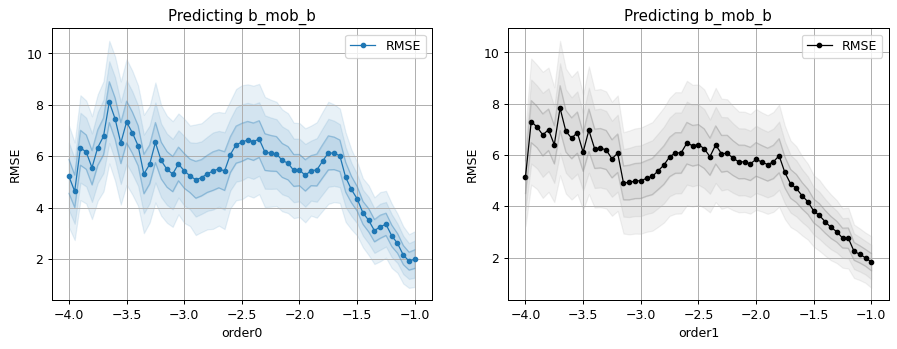

In [77]:
# Check the performance
REN = numpy.sqrt(20)

rmse0, rmse0s = [], []
rmse1, rmse1s = [], []
frac = numpy.linspace(-4, -1, 61)
delta = 0.15
for f in frac:
    mask0 = numpy.abs(f - valid_p[valid_mask].reset_index().order0) < delta    
    rmse0.append((b_mob_b_delta.mean(axis=0)[mask0]**2).mean())
    rmse0s.append(2*b_mob_b_delta.std(axis=0)[mask0].mean()*b_mob_a_delta.mean(axis=0)[mask0].mean()/REN)
    
    mask1 = numpy.abs(f - valid_p[valid_mask].reset_index().order1) < delta    
    rmse1.append((b_mob_b_delta.mean(axis=0)[mask1]**2).mean())
    rmse1s.append(2*b_mob_b_delta.std(axis=0)[mask1].mean()*b_mob_b_delta.mean(axis=0)[mask1].mean()/REN)

rmse0 = numpy.array(rmse0)
rmse1 = numpy.array(rmse1)
rmse0s = numpy.array(rmse0s)
rmse1s = numpy.array(rmse1s)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=90)
axes[0].plot(frac, rmse0, '.-', label='RMSE', linewidth=1, markersize=7)
axes[0].plot(frac, rmse0 + rmse0s, '-', linewidth=1, markersize=7, alpha=0.3, color='tab:blue')
axes[0].plot(frac, rmse0 - rmse0s, '-', linewidth=1, markersize=7, alpha=0.3, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 1*rmse0s, y2=rmse0 + 1*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 2*rmse0s, y2=rmse0 + 2*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 3*rmse0s, y2=rmse0 + 3*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].legend(); axes[0].grid(); axes[0].set_xlabel('order0'); axes[0].set_ylabel('RMSE')

axes[1].plot(frac, rmse1, 'k.-', label='RMSE', linewidth=1, markersize=7)
axes[1].plot(frac, rmse1 + rmse1s, '-', linewidth=1, markersize=7, alpha=0.3, color='grey')
axes[1].plot(frac, rmse1 - rmse1s, '-', linewidth=1, markersize=7, alpha=0.3, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 1*rmse1s, y2=rmse1 + 1*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 2*rmse1s, y2=rmse1 + 2*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 3*rmse1s, y2=rmse1 + 3*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].legend(); axes[1].grid(); axes[1].set_xlabel('order1'); axes[1].set_ylabel('RMSE')

axes[0].set_title('Predicting b_mob_b')
axes[1].set_title('Predicting b_mob_b')
plt.show()

### Train Networks (s_mob_a)

In [48]:
"""Construct a dataset and shuffle the data."""
training_dataset = tensorflow.data.Dataset.from_tensor_slices(
    (train_x, train_target_normalized.s_mob_a)).shuffle(buffer_size=10**5, seed=42).batch(32)
training_dataset

<BatchDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float64)>

In [49]:
"""Build a simple neural network."""
s_mob_a_logs = []
s_mob_a_delta = []
for i in range(20):
    # Build
    m0 = tensorflow.keras.Sequential([
        tensorflow.keras.layers.Dense(2048, activation='relu', input_shape=(2048,)),
        tensorflow.keras.layers.Dropout(0.2),
        tensorflow.keras.layers.Dense(1, activation='linear')
    ])

    # Compile
    m0.compile(
        optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss=tensorflow.keras.losses.MeanSquaredError(),
        metrics=[
            tensorflow.keras.metrics.MeanAbsoluteError(name='mae'),
            tensorflow.keras.metrics.MeanAbsolutePercentageError(name='mape')],
    )

    # Train
    callback = tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_mae', patience=4, min_delta=0.001, mode='min'
    )
    m0_log =  m0.fit(
        training_dataset, epochs=30, verbose=0, callbacks=[callback],
        validation_data=(valid_x, valid_target_normalized.s_mob_a),
    )
    
    # Predict
    valid_pred = pandas.DataFrame(
        m0.predict(valid_x)*100, columns=['s_mob_a'])
    valid_delta = numpy.abs(
        valid_pred.copy().reset_index(drop=True) - valid_target.copy().reset_index(drop=True)).s_mob_a
    
    # Save
    s_mob_a_logs.append(m0_log)
    s_mob_a_delta.append(valid_delta)
    
    del m0
    
s_mob_a_delta = numpy.array(s_mob_a_delta)
s_mob_a_delta.shape

(20, 12400)

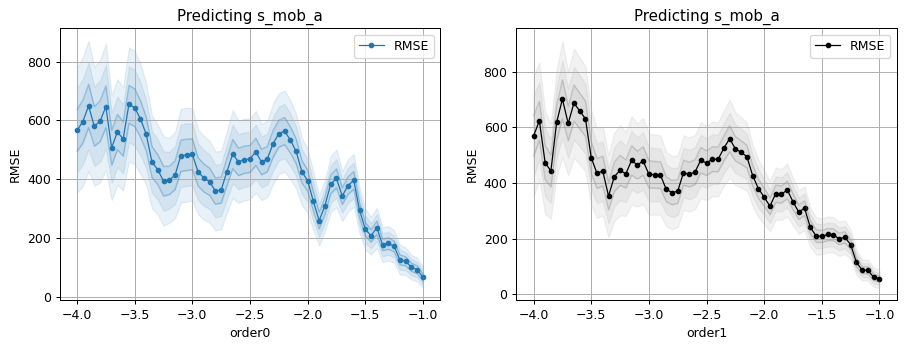

In [78]:
# Check the performance
REN = numpy.sqrt(20)

rmse0, rmse0s = [], []
rmse1, rmse1s = [], []
frac = numpy.linspace(-4, -1, 61)
delta = 0.15
for f in frac:
    mask0 = numpy.abs(f - valid_p[valid_mask].reset_index().order0) < delta    
    rmse0.append((s_mob_a_delta.mean(axis=0)[mask0]**2).mean())
    rmse0s.append(2*s_mob_a_delta.std(axis=0)[mask0].mean()*s_mob_a_delta.mean(axis=0)[mask0].mean()/REN)
    
    mask1 = numpy.abs(f - valid_p[valid_mask].reset_index().order1) < delta    
    rmse1.append((s_mob_a_delta.mean(axis=0)[mask1]**2).mean())
    rmse1s.append(2*s_mob_a_delta.std(axis=0)[mask1].mean()*s_mob_a_delta.mean(axis=0)[mask1].mean()/REN)

rmse0 = numpy.array(rmse0)
rmse1 = numpy.array(rmse1)
rmse0s = numpy.array(rmse0s)
rmse1s = numpy.array(rmse1s)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=90)
axes[0].plot(frac, rmse0, '.-', label='RMSE', linewidth=1, markersize=7)
axes[0].plot(frac, rmse0 + rmse0s, '-', linewidth=1, markersize=7, alpha=0.3, color='tab:blue')
axes[0].plot(frac, rmse0 - rmse0s, '-', linewidth=1, markersize=7, alpha=0.3, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 1*rmse0s, y2=rmse0 + 1*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 2*rmse0s, y2=rmse0 + 2*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 3*rmse0s, y2=rmse0 + 3*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].legend(); axes[0].grid(); axes[0].set_xlabel('order0'); axes[0].set_ylabel('RMSE')

axes[1].plot(frac, rmse1, 'k.-', label='RMSE', linewidth=1, markersize=7)
axes[1].plot(frac, rmse1 + rmse1s, '-', linewidth=1, markersize=7, alpha=0.3, color='grey')
axes[1].plot(frac, rmse1 - rmse1s, '-', linewidth=1, markersize=7, alpha=0.3, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 1*rmse1s, y2=rmse1 + 1*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 2*rmse1s, y2=rmse1 + 2*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 3*rmse1s, y2=rmse1 + 3*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].legend(); axes[1].grid(); axes[1].set_xlabel('order1'); axes[1].set_ylabel('RMSE')

axes[0].set_title('Predicting s_mob_a')
axes[1].set_title('Predicting s_mob_a')
plt.show()

### Train Networks (s_mob_b)

In [51]:
"""Construct a dataset and shuffle the data."""
training_dataset = tensorflow.data.Dataset.from_tensor_slices(
    (train_x, train_target_normalized.s_mob_b)).shuffle(buffer_size=10**5, seed=42).batch(32)
training_dataset

<BatchDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float64)>

In [52]:
"""Build a simple neural network."""
s_mob_b_logs = []
s_mob_b_delta = []
for i in range(20):
    # Build
    m0 = tensorflow.keras.Sequential([
        tensorflow.keras.layers.Dense(2048, activation='relu', input_shape=(2048,)),
        tensorflow.keras.layers.Dropout(0.2),
        tensorflow.keras.layers.Dense(1, activation='linear')
    ])

    # Compile
    m0.compile(
        optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss=tensorflow.keras.losses.MeanSquaredError(),
        metrics=[
            tensorflow.keras.metrics.MeanAbsoluteError(name='mae'),
            tensorflow.keras.metrics.MeanAbsolutePercentageError(name='mape')],
    )

    # Train
    callback = tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_mae', patience=4, min_delta=0.001, mode='min'
    )
    m0_log =  m0.fit(
        training_dataset, epochs=30, verbose=0, callbacks=[callback],
        validation_data=(valid_x, valid_target_normalized.s_mob_b),
    )
    
    # Predict
    valid_pred = pandas.DataFrame(
        m0.predict(valid_x)*100, columns=['s_mob_b'])
    valid_delta = numpy.abs(
        valid_pred.copy().reset_index(drop=True) - valid_target.copy().reset_index(drop=True)).s_mob_b
    
    # Save
    s_mob_b_logs.append(m0_log)
    s_mob_b_delta.append(valid_delta)
    
    del m0
    
s_mob_b_delta = numpy.array(s_mob_b_delta)
s_mob_b_delta.shape

(20, 12400)

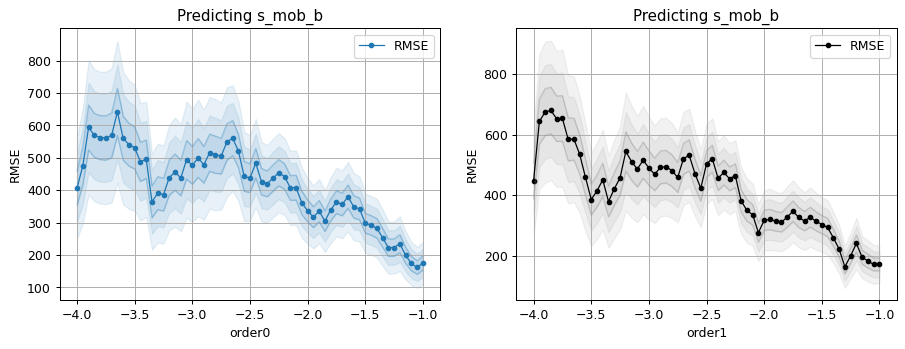

In [79]:
# Check the performance
REN = numpy.sqrt(20)

rmse0, rmse0s = [], []
rmse1, rmse1s = [], []
frac = numpy.linspace(-4, -1, 61)
delta = 0.15
for f in frac:
    mask0 = numpy.abs(f - valid_p[valid_mask].reset_index().order0) < delta    
    rmse0.append((s_mob_b_delta.mean(axis=0)[mask0]**2).mean())
    rmse0s.append(2*s_mob_b_delta.std(axis=0)[mask0].mean()*s_mob_b_delta.mean(axis=0)[mask0].mean()/REN)
    
    mask1 = numpy.abs(f - valid_p[valid_mask].reset_index().order1) < delta    
    rmse1.append((s_mob_b_delta.mean(axis=0)[mask1]**2).mean())
    rmse1s.append(2*s_mob_b_delta.std(axis=0)[mask1].mean()*s_mob_b_delta.mean(axis=0)[mask1].mean()/REN)

rmse0 = numpy.array(rmse0)
rmse1 = numpy.array(rmse1)
rmse0s = numpy.array(rmse0s)
rmse1s = numpy.array(rmse1s)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=90)
axes[0].plot(frac, rmse0, '.-', label='RMSE', linewidth=1, markersize=7)
axes[0].plot(frac, rmse0 + rmse0s, '-', linewidth=1, markersize=7, alpha=0.3, color='tab:blue')
axes[0].plot(frac, rmse0 - rmse0s, '-', linewidth=1, markersize=7, alpha=0.3, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 1*rmse0s, y2=rmse0 + 1*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 2*rmse0s, y2=rmse0 + 2*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 3*rmse0s, y2=rmse0 + 3*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].legend(); axes[0].grid(); axes[0].set_xlabel('order0'); axes[0].set_ylabel('RMSE')

axes[1].plot(frac, rmse1, 'k.-', label='RMSE', linewidth=1, markersize=7)
axes[1].plot(frac, rmse1 + rmse1s, '-', linewidth=1, markersize=7, alpha=0.3, color='grey')
axes[1].plot(frac, rmse1 - rmse1s, '-', linewidth=1, markersize=7, alpha=0.3, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 1*rmse1s, y2=rmse1 + 1*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 2*rmse1s, y2=rmse1 + 2*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 3*rmse1s, y2=rmse1 + 3*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].legend(); axes[1].grid(); axes[1].set_xlabel('order1'); axes[1].set_ylabel('RMSE')

axes[0].set_title('Predicting s_mob_b')
axes[1].set_title('Predicting s_mob_b')
plt.show()

### Train Networks (vel)

In [37]:
"""Construct a dataset and shuffle the data."""
training_dataset = tensorflow.data.Dataset.from_tensor_slices(
    (train_x, train_target_normalized.vel)).shuffle(buffer_size=10**5, seed=42).batch(32)
training_dataset

<BatchDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float64)>

In [38]:
"""Build a simple neural network."""
vel_logs = []
vel_delta = []
for i in range(20):
    # Build
    m0 = tensorflow.keras.Sequential([
        tensorflow.keras.layers.Dense(2048, activation='relu', input_shape=(2048,)),
        tensorflow.keras.layers.Dropout(0.2),
        tensorflow.keras.layers.Dense(1, activation='linear')
    ])

    # Compile
    m0.compile(
        optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss=tensorflow.keras.losses.MeanSquaredError(),
        metrics=[
            tensorflow.keras.metrics.MeanAbsoluteError(name='mae'),
            tensorflow.keras.metrics.MeanAbsolutePercentageError(name='mape')],
    )

    # Train
    callback = tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_mae', patience=4, min_delta=0.001, mode='min'
    )
    m0_log =  m0.fit(
        training_dataset, epochs=30, verbose=0, callbacks=[callback],
        validation_data=(valid_x, valid_target_normalized.vel),
    )
    
    # Predict
    valid_pred = pandas.DataFrame(
        m0.predict(valid_x), columns=['vel'])
    valid_delta = numpy.abs(
        valid_pred.copy().reset_index(drop=True) - valid_target.copy().reset_index(drop=True)).vel
    
    # Save
    vel_logs.append(m0_log)
    vel_delta.append(valid_delta)
    
    del m0
    
vel_delta = numpy.array(vel_delta)
vel_delta.shape

(20, 12420)

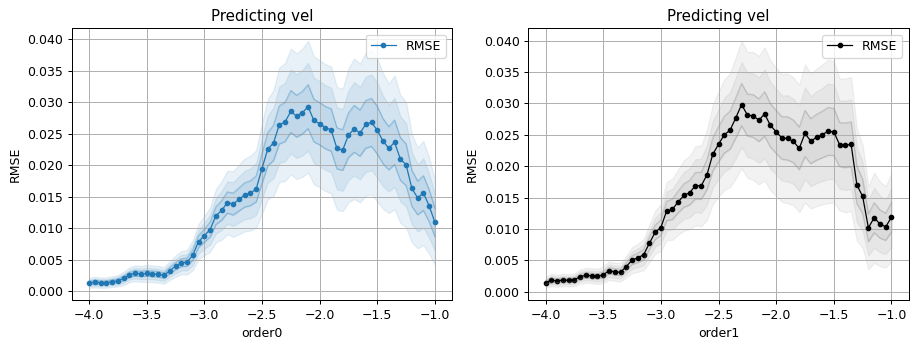

In [39]:
# Check the performance
REN = numpy.sqrt(20)

rmse0, rmse0s = [], []
rmse1, rmse1s = [], []
frac = numpy.linspace(-4, -1, 61)
delta = 0.15
for f in frac:
    mask0 = numpy.abs(f - valid_p[valid_mask].reset_index().order0) < delta    
    rmse0.append((vel_delta.mean(axis=0)[mask0]**2).mean())
    rmse0s.append(2*vel_delta.std(axis=0)[mask0].mean()*vel_delta.mean(axis=0)[mask0].mean()/REN)
    
    mask1 = numpy.abs(f - valid_p[valid_mask].reset_index().order1) < delta    
    rmse1.append((vel_delta.mean(axis=0)[mask1]**2).mean())
    rmse1s.append(2*vel_delta.std(axis=0)[mask1].mean()*vel_delta.mean(axis=0)[mask1].mean()/REN)

rmse0 = numpy.array(rmse0)
rmse1 = numpy.array(rmse1)
rmse0s = numpy.array(rmse0s)
rmse1s = numpy.array(rmse1s)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=90)
axes[0].plot(frac, rmse0, '.-', label='RMSE', linewidth=1, markersize=7)
axes[0].plot(frac, rmse0 + rmse0s, '-', linewidth=1, markersize=7, alpha=0.3, color='tab:blue')
axes[0].plot(frac, rmse0 - rmse0s, '-', linewidth=1, markersize=7, alpha=0.3, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 1*rmse0s, y2=rmse0 + 1*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 2*rmse0s, y2=rmse0 + 2*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].fill_between(frac, y1=rmse0 - 3*rmse0s, y2=rmse0 + 3*rmse0s, linewidth=1, alpha=0.1, color='tab:blue')
axes[0].legend(); axes[0].grid(); axes[0].set_xlabel('order0'); axes[0].set_ylabel('RMSE')

axes[1].plot(frac, rmse1, 'k.-', label='RMSE', linewidth=1, markersize=7)
axes[1].plot(frac, rmse1 + rmse1s, '-', linewidth=1, markersize=7, alpha=0.3, color='grey')
axes[1].plot(frac, rmse1 - rmse1s, '-', linewidth=1, markersize=7, alpha=0.3, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 1*rmse1s, y2=rmse1 + 1*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 2*rmse1s, y2=rmse1 + 2*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].fill_between(frac, y1=rmse1 - 3*rmse1s, y2=rmse1 + 3*rmse1s, linewidth=1, alpha=0.1, color='grey')
axes[1].legend(); axes[1].grid(); axes[1].set_xlabel('order1'); axes[1].set_ylabel('RMSE')

axes[0].set_title('Predicting vel')
axes[1].set_title('Predicting vel')
plt.show()